In [184]:
import gensim
import pandas as pd
import pickle
import seaborn as sns
import pyLDAvis.gensim

from tqdm._tqdm_notebook import tqdm_notebook as tqdm
#initialize tqdm
tqdm.pandas()
sns.set_style('darkgrid')

In [94]:
len(topic_titles)

82

In [137]:
DATA_DIR = '../../data/reddit/Article_data_2019/'
useful_topics = [2,4,6,7,8,9,12,13,14,17,18,19,20,21,22,23,24,26,28,29,30,31,32,33,34,35,38,42,44,45,46,47,48,50,51,
                 52,53,55,58,61,62,63,64,66,67,68,69,70,71,75,77,78,79,80,85,86,87,88,89,91,92,93,96,99]

topic_titles = ['2020 election', 'trump administration', 'climate change', 'trump foreign policy', 'mueller report', 
                'cohen', 'williamson', '2018 congress', 'border', 'first debate', 'hunder biden', 'town hall', 
                'first debate', 'biden busing', 'female congresswomen', 'nxivm sex cult', 'auto industry', 
                'assange', 'healthcare', 'de blasio', 'buttigieg', 'impeachment', 
                'us economy (socialism vs captialism)', 'economic foreign policy', 'iowa caucus', 
                'north carolina voter fraud', 'north korea', 'jean carroll', '2020 election', 'kavanaugh', 
                'harris', 'mccain', 'aoc', 'sanders', 'border', 'prison reform', 'getty', 'graham', 
                '2020 democratic primary', 'stephanopoulos', 'tax fact check', 'generic words', 'o\'rourke', 
                'media words', 'drugs', 'venezuela', 'tech', 'iran', 'assange', 'random', 'healthcare', 
                'harris', 'student debt', 'russian interference', 'politico', 'booker', 'socialism', 
                'megan davis', 'lgbtq', 'swalwell', 'former counsel for mueller report', 'trump racist', 
                'sanders', 'sanders', 'puerto rico', 'reuters', 'hickenlooper', 'tax return', 'supreme court', 
                '2020 democratic primary', 'electoral college', 'inslee', 'gravel', 'generic words', 'socialism', 
                'marijuana', 'maher', 'gun laws', 'yang', 'unions', '2020 democratic primary', 'media words', 
                'hamilton musical??', 'pundits', 'stacey abrams', 'trump', 'warren', 'israel', 'congress', 'harris', 
                'southern racism', 'civil rights', 'busing', 'north korea', 'gold', 'stufff', 'mcconnell', 'stuffs', 
                'generic words', 'iran/afghanistan']

candidates = ["SANDERS","DELANEY","WARREN","HARRIS","GILLIBRAND","O'ROURKE","KLOBUCHAR","BOOKER",
    "BUTTIGIEG","GABBARD","YANG","INSLEE","HICKENLOOPER","WILLIAMSON","TULSI","CASTRO","BIDEN", "BERNIE",
    "BETO", "ROURKE", "BENNETT", "BULLOCK", "BLASIO", "TIM RYAN", "GRAVEL"]
candidates = set([x.lower() for x in candidates])

candidate_dict = {'klobuchar': 'klobuchar',
 'bennett': 'bennett',
 'booker': 'booker',
 'warren': 'warren',
 'castro': 'castro',
 'williamson': 'williamson',
 'gabbard': 'gabbard',
 'bernie': 'sanders',
 "o'rourke": "o_rourke",
 'bullock': 'bullock',
 #'tim ryan': 'tim_ryan',
 'sanders': 'sanders',
 'biden': 'biden',
 'hickenlooper': 'hickenlooper',
 'blasio': 'de_blasio',
 'yang': 'yang',
 'delaney': 'delaney',
 'gillibrand': 'gillibrand',
 'beto': 'o_rourke',
 'harris': 'harris',
 'inslee': 'inslee',
 'rourke': 'o_rourke',
 'gravel': 'gravel',
 'tulsi': 'gabbard',
 'buttigieg': 'buttigieg'}

In [43]:
# source data
filename = DATA_DIR + 'LDA/df.pkl'
df = pd.read_pickle(filename)

In [186]:
# model and corpus
model = gensim.models.LdaModel.load(DATA_DIR + '/LDA/models/100_model_10_article_text_2019_candidate_only_len4.gensim')
dictionary = gensim.corpora.Dictionary.load(DATA_DIR + 'LDA/article_text_2019_candidate_only_dictionary.gensim')
corpus = pickle.load(open(DATA_DIR + 'LDA/article_text_2019_candidate_only' + '_corpus.pkl', 'rb'))
p = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.save_html(p, DATA_DIR + 'LDA/lda_vis.html')

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence

In [139]:
df['corpus'] = df.text_lemmas.progress_map(lambda x: dictionary.doc2bow(x))
df['topics'] = df.corpus.progress_map(lambda x: list(filter(lambda y: y[0] in useful_topics,model[x])))

In [140]:
def vector_concatenator(vector):
    v = [(topic_titles[y[0]], y[1]) for y in vector]
    v_final = dict()
    for t in v:
        if t[0] in v_final.keys():
            v_final[t[0]] += t[1]
        else:
            v_final[t[0]] = t[1]
    return list(zip(v_final.keys(), v_final.values()))

df['topic_titles'] = df.topics.progress_map(vector_concatenator)

In [141]:
def intersection(lemma): 
    lemma = [token.lower() for token in lemma]
    intersect = candidates.intersection(lemma)
    return {candidate_dict[x] for x in intersect}

df['candidate_title'] = df['title_lemmas'].progress_map(intersection)
df['candidate_text'] = df['text_lemmas'].progress_map(intersection)

In [142]:
df.to_csv(DATA_DIR + 'final_top_topics_news_articles.csv')
df.to_pickle(DATA_DIR + 'final_top_topics_news_articles.pkl')

In [13]:
df = pd.read_pickle(DATA_DIR + 'final_top_topics_news_articles.csv')

### Aggregated in Time Series

In [143]:
### get date dataframes
df_date = pd.read_pickle(DATA_DIR + 'reddit_2019jun16tojul1_dates.pkl')
df_date = df_date.append(pd.read_pickle(DATA_DIR + 'reddit_2019_dates.pkl'))
df_date = df_date.append(pd.read_csv(DATA_DIR + 'dates_missing_ids.csv', index_col=0))

In [174]:
df2 = df.merge(df_date, on='id', how='left') #df.join(df_date, on='id', how='left')
df2['day'] = pd.to_datetime(df2['created_utc'], yearfirst=True).dt.round('d')
df2['week']= df2['day'] - pd.to_timedelta(df2['day'].dt.dayofweek, unit='d')
df2['candidate_text'] = df2.candidate_text.map(lambda x: list(x))
df2['counter'] = 1
df2.counter = df2.counter.astype('object')

In [219]:
time = 'week' # day

def vector_concatenator(row):
    vector = row.topic_titles
    v_final = dict()
    for t in vector:
        if t[0] in v_final.keys():
            v_final[t[0]] += t[1]
        else:
            v_final[t[0]] = t[1]
    return list(zip(v_final.keys(), map(lambda x: x/row.counter, v_final.values())))

def vector_counter(row):
    vector = row.candidate_text
    v_final = dict()
    for t in vector:
        if t in v_final.keys():
            v_final[t] += 1
        else:
            v_final[t] = 1
    return list(zip(v_final.keys(), map(lambda x: x/row.counter, v_final.values())))

def normalize_topics(row):
    tt = row.topic_titles.copy()
    s = 0
    for x in tt:
        s += x[1]
        
    for i in range(len(tt)):
        tt[i] = (tt[i][0], tt[i][1]*(1.0/s))
        
    return tt

candidate_dfs = dict()
for candidate in set(candidate_dict.values()):
    candidate_dfs[candidate] = df2[df2.candidate_text.map(lambda x: candidate in x)]\
                                [['counter', 'score', 'candidate_text', 'topic_titles', time]]\
                                .groupby(time).agg(sum)
    candidate_dfs[candidate].topic_titles = candidate_dfs[candidate].apply(vector_concatenator, axis=1)
    candidate_dfs[candidate].candidate_text = candidate_dfs[candidate].apply(vector_counter, axis=1)
    candidate_dfs[candidate].topic_titles = candidate_dfs[candidate].apply(normalize_topics, axis=1)
df2_agg = df2[['counter', 'score', 'candidate_text', 'topic_titles', time]].groupby(time).agg(sum)
df2_agg.topic_titles = df2_agg.apply(vector_concatenator, axis=1)
df2_agg.candidate_text = df2_agg.apply(vector_counter, axis=1)
df2_agg.topic_titles = df2_agg.apply(normalize_topics, axis=1)
candidate_dfs['none'] = df2_agg

In [187]:
!mkdir {DATA_DIR + 'candidate_aggregation/'}
for candidate in set(candidate_dict.values()):
    candidate_dfs[candidate].to_csv(DATA_DIR + 'candidate_aggregation/' + candidate + '.csv')

mkdir: ../../data/reddit/Article_data_2019/candidate_aggregation/: File exists


In [70]:
candidate_dfs = dict()
for candidate in set(candidate_dict.values()):
    candidate_dfs[candidate] = pd.read_csv(DATA_DIR + 'candidate_aggregation/' + candidate + '.csv')

In [220]:
candidate_dfs['harris']

,counter,score,candidate_text,topic_titles
week,,,,
2018-12-31,28,28,"[(klobuchar, 0.14285714285714285), (harris, 1....","[(first debate, 0.05299079834711036), (de blas..."
2019-01-07,169,183,"[(harris, 1.0), (sanders, 0.42011834319526625)...","[(2018 congress, 0.03379365606889881), (health..."
2019-01-14,39,39,"[(harris, 1.0), (booker, 0.41025641025641024),...","[(first debate, 0.08069486553278238), (female ..."
2019-01-21,212,212,"[(harris, 1.0), (warren, 0.5424528301886793), ...","[(first debate, 0.07254402067626409), (sanders..."
2019-01-28,237,414,"[(warren, 0.5316455696202531), (harris, 1.0), ...","[(healthcare, 0.07377280617184669), (us econom..."
2019-02-04,146,146,"[(harris, 1.0), (sanders, 0.4041095890410959),...","[(2018 congress, 0.022687578543293663), (borde..."
2019-02-11,159,40806,"[(harris, 1.0), (sanders, 0.48427672955974843)...","[(2020 election, 0.05362063852003861), (sander..."
2019-02-18,272,221357,"[(harris, 1.0), (sanders, 0.6029411764705882),...","[(border, 0.0200911378593054), (2020 election,..."
2019-02-25,252,74221,"[(harris, 1.0), (biden, 0.3055555555555556), (...","[(2020 election, 0.08356548465591004), (harris..."


In [181]:
idxs = [2,4,6,7,8,9,12,13,14,17,18,19,20,21,22,23,24,26,28,29,30,31,32,33,34,35,38,42,44,45,46,47,48,50,51,
                 52,53,55,58,61,62,63,64,66,67,68,69,70,71,75,77,78,79,80,85,86,87,88,89,91,92,93,96,99]
{topic_titles[i] for i in useful_topics}

{'2018 congress',
 '2020 democratic primary',
 '2020 election',
 'aoc',
 'assange',
 'biden busing',
 'booker',
 'border',
 'busing',
 'buttigieg',
 'civil rights',
 'climate change',
 'congress',
 'de blasio',
 'drugs',
 'economic foreign policy',
 'electoral college',
 'female congresswomen',
 'first debate',
 'gun laws',
 'harris',
 'healthcare',
 'hickenlooper',
 'impeachment',
 'inslee',
 'iowa caucus',
 'iran',
 'iran/afghanistan',
 'israel',
 'kavanaugh',
 'lgbtq',
 'marijuana',
 'mccain',
 'mcconnell',
 'mueller report',
 'north korea',
 "o'rourke",
 'prison reform',
 'puerto rico',
 'russian interference',
 'sanders',
 'student debt',
 'supreme court',
 'tax return',
 'tech',
 'trump',
 'trump racist',
 'unions',
 'us economy (socialism vs captialism)',
 'venezuela',
 'warren',
 'williamson',
 'yang'}

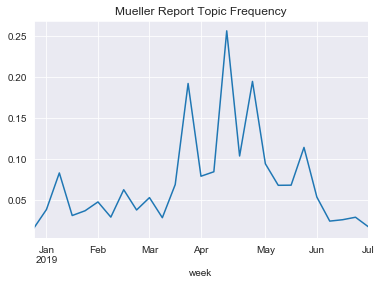

In [227]:
def plot_topic_df(dataframe, topic):

    def extract_topic(row):
        topic_list = list(filter(lambda y: y[0] == topic, row.topic_titles))
        if len(topic_list) == 0:
            return 0
        else:
            return topic_list[0][1]
         

    dataframe[dataframe.counter > 10]\
        .apply(extract_topic, axis =1)\
        .plot(title='{} Topic Frequency'.format(topic).title())
    
#df2_agg
c = 'none'
plot_topic_df(candidate_dfs[c][candidate_dfs[c].counter > 10], 'mueller report')

In [213]:
def topic_df(dataframe, topic):

    def extract_topic(row):
        topic_list = list(filter(lambda y: y[0] == topic, row.topic_titles))
        if len(topic_list) == 0:
            return 0
        else:
            return topic_list[0][1]
         

    return dataframe[dataframe.counter > 10]\
                .apply(extract_topic, axis =1)
topic_df(candidate_dfs[c][candidate_dfs[c].counter > 10], 'israel')

day
2019-01-02    0.000000
2019-01-03    0.004406
2019-01-06    0.005436
2019-01-07    0.000000
2019-01-08    0.001215
2019-01-09    0.000000
2019-01-10    0.001665
2019-01-11    0.000000
2019-01-12    0.003801
2019-01-13    0.000000
2019-01-15    0.000000
2019-01-16    0.000000
2019-01-19    0.013199
2019-01-22    0.003397
2019-01-23    0.000000
2019-01-24    0.000000
2019-01-25    0.011236
2019-01-26    0.000000
2019-01-27    0.000000
2019-01-28    0.000000
2019-01-29    0.006554
2019-01-30    0.004153
2019-02-01    0.000615
2019-02-02    0.004907
2019-02-03    0.002237
2019-02-04    0.000000
2019-02-07    0.000000
2019-02-08    0.000526
2019-02-09    0.001590
2019-02-10    0.000000
                ...   
2019-05-24    0.000000
2019-05-25    0.008744
2019-05-26    0.000000
2019-05-27    0.008007
2019-05-28    0.001612
2019-05-29    0.000228
2019-05-30    0.000378
2019-05-31    0.000000
2019-06-01    0.000208
2019-06-02    0.000000
2019-06-03    0.000970
2019-06-04    0.001109
2019-06

In [218]:
df2[(df2.candidate_text.map(lambda x: c in x)) & (df2.day == '2019-01-25')].loc[8293]

id                                                                  ajcbov
num_comments                                                            34
score                                                                    1
subreddit                                                         politics
subreddit_subscribers                                              4575520
title                    What You Can’t Say About Israel (With Marc Lam...
url                      https://theintercept.com/2019/01/24/what-you-c...
authors                                                                 []
date_download                                          2019-06-10 05:04:38
date_modify                                                           None
date_publish                                           2019-01-24 11:01:22
description              There are signs that U.S. opinion might be shi...
filename                 https%3A%2F%2Ftheintercept.com%2F2019%2F01%2F2...
image_url                